# Semi-Supervised Learning

As we've seen in the lecture. In semi-supervised learning (SSL), we are provided with a dataset containing both labeled and unlabeled examples. The portion of labeled examples is usually quite small compared to the unlabeled example (e.g., 1 to 10% of the total number of examples). During training, the objective, or rather hope, is to leverage the unlabeled examples to train a better performing model than what can be obtained using only the labeled portion. And hopefully, get closer to the desired optimal performance, in which all of the dataset is labeled.

In this lab, we'll try to get a better understanding of the methods discussed in the course. First we'll start with a synthetic dataset (Two moons). Then we'll go to a real dataset.

## Two Moons Dataset

At first, we'll start with two moons dataset, wich is a dataset with two classes, each element is two dimensionnal (2d coordinates) and we have two classes. The two classes are circular in shpae as illustrated bellow.

![](https://cpb-us-e1.wpmucdn.com/blogs.rice.edu/dist/9/7567/files/2015/01/fasta_two_moons.png)

### Generate Data

The first step is to create a simple function that generates the data. In our case, after generating the data with two classes. We need to return a labeled set, and the rest an unlabeled. Here we'll keep things simple. We'll chose ourselves 6 data points as labeled, with three examples as class 0 and three as class 1. In addition to 2N randomly generated samples, N for each class.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import time
import random
import math

# Two have comparable resutls
np.random.seed(1)
torch.manual_seed(1)

In [ ]:
def generate_two_moons_dataset(N, scale):
    ''' Generate two moons dataset '''

    # 2N Unlabeled Data points
    x_linspace = np.linspace(0, np.pi, num=N)
    x_class0 = np.array([x_linspace, np.sin(x_linspace)]).T
    x_class1 = -1 * x_class0 + [np.pi / 2 + 0.1, 0.15]

    x_class0 += np.random.normal(scale=scale, size=(N, 2))
    x_class1 += np.random.normal(scale=scale, size=(N, 2))
    unlabeled_data = np.vstack([x_class0, x_class1])

    # 6 Labeled Data points
    labeled_data = np.zeros((6, 2))
    labeled_data[0] = [1.1, 1.]
    labeled_data[1] = [2., 1.]
    labeled_data[2] = [2.9, 0.3]
    labeled_data[3] = [-0.8, -0.5]
    labeled_data[4] = [0, - 0.8]
    labeled_data[5] = [1, - 0.5]

    # Create dataset tensors
    inputs = np.vstack([unlabeled_data, labeled_data])
    inputs = torch.from_numpy(inputs).float()
    labels_sup = torch.FloatTensor([0, 0, 0, 1, 1, 1]).view(-1, 1)
    labels_data = torch.cat((torch.zeros(N, 1), torch.ones(N, 1), labels_sup))

    return inputs, labels_sup, labels_data

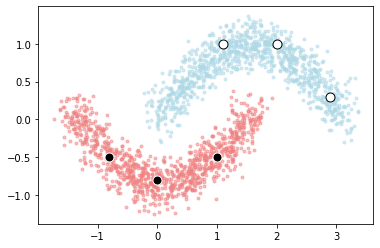

In [ ]:
# Generate dataset

# Number for unlabelled samples per class
N = 1000
# Noise scale
scale = 0.15

inputs, labels_sup, labels_data = generate_two_moons_dataset(N, scale)

# Plot data
plt.plot(inputs[(labels_data == 1).nonzero()[:, 0], 0].numpy(), inputs[(labels_data == 1).nonzero()[:, 0], 1].numpy(), '.', alpha=0.5,color='lightcoral')
plt.plot(inputs[(labels_data == 0).nonzero()[:, 0], 0].numpy(), inputs[(labels_data == 0).nonzero()[:, 0], 1].numpy(), '.', alpha=0.5,color='lightblue')
plt.plot(inputs[-6:-3, 0].numpy(), inputs[-6:-3, 1].numpy(), '.', alpha=1., markersize=18, color='white', markeredgecolor='black')
plt.plot(inputs[-3:, 0].numpy(), inputs[-3:, 1].numpy(), '.', alpha=1., markersize=18, color='black', markeredgecolor='white')
plt.show();

As we can see, we created a dataset with two classes. Each one with different colors. And to simulate a semi-supervised setting. All of the points are unlabeled (so we can't use their classes during training) except 6 examples. 3 from the red class, ploted in black. And 3 from the blue class ploted in white.

### Create model

Now let's create our first model. We'll use a very simple model with a series of linear layers with Relu activation in between. Since we only have two classes, the model we'll have a single output.


In [ ]:
# Create the model
def create_model():
    model = nn.Sequential(
        nn.Linear(2, 10),
        nn.ReLU(True),
        nn.Linear(10, 10),
        nn.ReLU(True),
        nn.Linear(10, 10),
        nn.ReLU(True),
        nn.Linear(10, 10),
        nn.ReLU(True),
        nn.Linear(10, 1)
    )

    # Initilize the parameters to follow a Gaussian
    model[0].weight.data = model[0].weight.data.normal_(0.0, np.sqrt(2.0 / 2))
    model[2].weight.data = model[2].weight.data.normal_(0.0, np.sqrt(2.0 / 10))
    model[4].weight.data = model[4].weight.data.normal_(0.0, np.sqrt(2.0 / 10))
    model[6].weight.data = model[6].weight.data.normal_(0.0, np.sqrt(2.0 / 10))
    model[8].weight.data = model[8].weight.data.normal_(0.0, np.sqrt(2.0 / 10))

    return model

Let'us also create a plotting function that prints the accuracy and plots the deision boudary to clearly see the model's performance.

In [ ]:
def plot_and_print_results(inputs, labels_data, model):
      # Get predictions
      output = model(inputs)
      predicted_labels = (output > 0.).float()

      # Compute test accuracy
      test_acc = torch.mean((predicted_labels == labels_data).float()).item() * 100.
      print('Test Acc : {}'.format(test_acc))

      # Plot the ground truth data
      plt.plot(inputs[(labels_data == 1).nonzero()[:, 0], 0].numpy(), inputs[(labels_data == 1).nonzero()[:, 0], 1].numpy(), '.', alpha=0.5, color='lightcoral')
      plt.plot(inputs[(labels_data == 0).nonzero()[:, 0], 0].numpy(), inputs[(labels_data == 0).nonzero()[:, 0], 1].numpy(), '.', alpha=0.5, color='lightblue')
      plt.plot(inputs[-6:-3, 0].numpy(), inputs[-6:-3, 1].numpy(), '.', alpha=1., markersize=18, color='white', markeredgecolor='black')
      plt.plot(inputs[-3:, 0].numpy(), inputs[-3:, 1].numpy(), '.', alpha=1., markersize=18, color='black', markeredgecolor='white')

      # Print the model's decision boundary
      y, x = np.meshgrid(np.linspace(-1.5, 1.5, 200), np.linspace(-2, 3.5, 200))
      z = torch.sigmoid(model(torch.from_numpy(np.concatenate((np.reshape(x, (-1, 1)), np.reshape(y, (-1, 1))), axis=1)).float()))
      plt.pcolormesh(x, y, np.reshape(z.detach().numpy(), (200, 200)), cmap='coolwarm')
      plt.show();

### Supervised case

We first we'll start with the simplest case. We simply use the labeled data to train the model. Which is only 6 examples. And we'll see that the model in this case is far from the desired one. This is done simply by creating an optimizer, passing the data through the model, and then compute the loss and updating the model.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Test Acc : 90.37886261940002


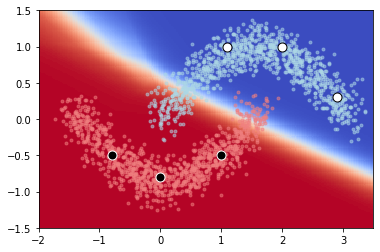

In [ ]:
# Create the model
model = create_model()

# Init optimizer (SGD+momentum)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Training
for _ in tqdm(range(2000)):
    # Forward pass
    output = model(inputs)

    # Compute loss and update parameters
    loss = -torch.mean(labels_sup * F.logsigmoid(output[-6:]) + (1 - labels_sup) * F.logsigmoid(-output[-6:]))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# See the results
plot_and_print_results(inputs, labels_data, model)

### Consistency Reguarization

Now, let's try some semi-supervised approaches. First, we'll see if consistency regularization can help us get a better model. In consistency regularization, in addition to the supervised loss (which is a binary cross entropy in our case), we'll add a unsupervised loss, which is the MSE distance between the model's original (or clean) output, and the model's output with noise. In a nutshell this is done as follows:

```
Supervised_Prediction = Model(InputLabeled)
SupervisedLoss = BinaryCE(Supervised_Prediction, Labels)

Unsupervised_Prediction_Clean = Model(InputUnlabeled)
Unsupervised_Prediction_Noisy = Model(InputUnlabeled + Noise)
UnsupervisedLoss = MSE(Unsupervised_Prediction_Clean, Unsupervised_Prediction_Noisy)
```

Let's translate this pseduo code into pytorch code:


In [ ]:
def inject_noise(inputs, noise_level= 0.1):
    with torch.no_grad():
      noise = noise_level * torch.Tensor(*inputs.size()).random_(-1, 2)

    return inputs + noise

def get_consistency_loss_weight(i):
    if i < 200:
        consistency_lambda = 0
    elif i < 1000:
        consistency_lambda = 10. * (i - 200) / 800
    else:
        consistency_lambda = 10.
      
    return consistency_lambda

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Test Acc : 99.95014667510986


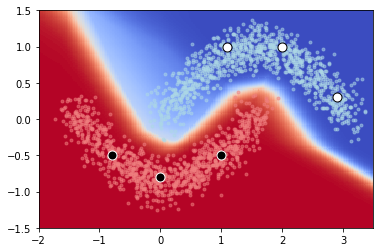

In [ ]:
# Create the model
model = create_model()

# Init optimizer (SGD+momentum)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Training
for _ in tqdm(range(2000)):
    # Forward pass
    output = model(inputs)

    # Supervised loss
    supervised_loss = -torch.mean(labels_sup * F.logsigmoid(output[-6:]) + (1 - labels_sup) * F.logsigmoid(-output[-6:]))

    # Unsupervised loss
    noisy_input = inject_noise(inputs)
    noisy_outputs = model(noisy_input)

    # here the weigh start at zero then slowly ramps up to 10. 
    unsupervised_loss_weight = get_consistency_loss_weight(i)
    unsupervised_loss = torch.mean((torch.sigmoid(output) - torch.sigmoid(noisy_outputs)) ** 2)

    # total loss
    loss = unsupervised_loss_weight * unsupervised_loss + supervised_loss

    # update paramters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# See the results
plot_and_print_results(inputs, labels_data, model)

### Pseudo labeling

Your turn:

Following the same procedure, try implementing pseudo labeling. As we've seen in the lecture, in pseudo labeling, the small amount of labeled data is first used to train the model. The trained model is then used to assign pseudo-labels to the unlabeled data points.

![](https://i.ibb.co/s2TyG06/screenshot.png)


## CIFAR 10

Now we are going to test the semi supervised approches on a more realistic datasets. Specifically, we are going to use CIFAR 10 dataset.

This section we'll be based on the following paper https://arxiv.org/abs/1804.09170 and its publically availble implementations. You are encouraged to read the paper to better understand the following code;



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import os

In [ ]:
assert torch.cuda.is_available(), "Please activate the GPU, Edit > Notebook settings"
device = "cuda"
torch.backends.cudnn.benchmark = True

### Dataset creation

The first set is two create our dataset. So we'll need to download CIFAR 10 dataset, then split it into two paritions: labeled and unlabeled dataset.

In [ ]:
!wget -nv https://raw.githubusercontent.com/perrying/realistic-ssl-evaluation-pytorch/master/build_dataset.py -O build_dataset.py

2020-12-01 20:26:41 URL:https://raw.githubusercontent.com/perrying/realistic-ssl-evaluation-pytorch/master/build_dataset.py [5493/5493] -> "build_dataset.py" [1]


Let's create split CIFAR 10 dataset. CIFAR 10 dataset originaly consists of "train": 45000, "test": 10000, "valid": 5000. So first, let split the training dataset into 4000 labeled examples, and the rest (41000 images) as unlabeled.

In [ ]:
!python build_dataset.py --nlabels 4000 --dataset cifar10

170500096it [00:08, 21029596.93it/s]                  
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
tcmalloc: large alloc 1228800000 bytes == 0x19b8a000 @  0x7fdf3beaf1e7 0x7fdeec4dc5e1 0x7fdeec540c78 0x7fdeec542ff6 0x7fdeec5d0f87 0x50a4a5 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x50ad03 0x634e72 0x634f27 0x6386df 0x639281 0x4b0dc0 0x7fdf3baacbf7 0x5b259a
tcmalloc: large alloc 1228800000 bytes == 0x62f6a000 @  0x7fdf3beaf1e7 0x7fdeec4dc5e1 0x7fdeec540c78 0x7fdeec540d93 0x7fdeec5f3fed 0x7fdeec5f494e 0x7fdeec5f72c8 0x7fdeec737276 0x7fdeec738d44 0x7fdeec73b492 0x7fdeec73c30e 0x5a9dac 0x50a433 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x50ad03 0x634e72 0x634f27 0x6386df 0x639281 0x4b0dc0 0x7fdf3baacbf7 0x5b259a
tcmalloc: large alloc 1511432192 bytes == 0x14d64e000 @  0x7fdf3beb02a4 0x591e47 0x4dd737 0x4e2b00 0x4e214a 0x4e0df8 0x4e255b 0x4e2924 0x4e2da4 0x4e214a 0x4e0df8 0x4e255b 0x4e33c6 0x4544bc 0x566aea 0x566f06 0x510e

Now let's create our dataset. We'll need four datasets, two for training, which will be the labeled and unlabled sets. Then one for validation and one for testing.

In [ ]:
# the data root
data_root = "data"

# dataset class
class CIFAR10:
    def __init__(self, root, split="l_train", transform=None):
        self.dataset = np.load(os.path.join(root, "cifar10", split+".npy"), allow_pickle=True).item()
        self.transform = transform

    def __getitem__(self, idx):
        image = self.dataset["images"][idx]
        if self.transform is not None:
          image = self.transfom(image)
        label = self.dataset["labels"][idx]
        return image, label

    def __len__(self):
        return len(self.dataset["images"])

# let's create the datasets
labeled_train_dataset = CIFAR10(root=data_root, split="l_train")
unlabeled_train_dataset = CIFAR10(root=data_root, split="u_train")
val_dataset = CIFAR10(root=data_root, split="val")
test_dataset = CIFAR10(root=data_root, split="test")


Let's make sure the sizes are correct. We want the labeled set to contain 4000 images and the unlabeled set to contain the rest, which is 41000

In [ ]:
assert len(labeled_train_dataset) == 4000
assert len(unlabeled_train_dataset) == 41000
print("all good")

all good


In [ ]:
print("labeled data : {}, unlabeled data : {}, training data : {}".format(len(labeled_train_dataset), len(unlabeled_train_dataset), len(labeled_train_dataset)+len(unlabeled_train_dataset)))
print("validation data : {}, test data : {}".format(len(val_dataset), len(test_dataset)))

labeled data : 4000, unlabeled data : 41000, training data : 45000
validation data : 5000, test data : 10000


As you can see, we have a batch of 50 images, each image is an RGB image with dimensions 32 x 32.

### Model

We are going to use a wide resnet model. Wide resnet is very similar to the resnet model, the only difference is that we control the number of channels of the bottleneck layer.

![](https://pytorch.org/assets/images/wide_resnet.png)

In [ ]:
!wget -nv https://raw.githubusercontent.com/perrying/realistic-ssl-evaluation-pytorch/master/lib/wrn.py wrn.py

2020-12-01 20:28:13 URL:https://raw.githubusercontent.com/perrying/realistic-ssl-evaluation-pytorch/master/lib/wrn.py [3664/3664] -> "wrn.py" [1]
wget: unable to resolve host address ‘wrn.py’
FINISHED --2020-12-01 20:28:13--
Total wall clock time: 0.1s
Downloaded: 1 files, 3.6K in 0s (90.4 MB/s)


This implementation of the model takes also a transform as input. As we've seen during in the lecture. For images, we need to apply some transformations as a source of noise. In our case we'll simply apply a horizental flip, croping and noise injection.

These transformations will be passed to the model, and will be applied at each forward pass during training.

In [ ]:
from wrn import WRN

# transformations, flip, crois and adding noise
class transform:
    def __init__(self, flip=True, r_crop=True, g_noise=True):
        self.flip = flip
        self.r_crop = r_crop
        self.g_noise = g_noise
        print("holizontal flip : {}, random crop : {}, gaussian noise : {}".format(
            self.flip, self.r_crop, self.g_noise
        ))

    def __call__(self, x):
        if self.flip and random.random() > 0.5:
            x = x.flip(-1)
        if self.r_crop:
            h, w = x.shape[-2:]
            x = F.pad(x, [2,2,2,2], mode="reflect")
            l, t = random.randint(0, 4), random.randint(0,4)
            x = x[:,:,t:t+h,l:l+w]
        if self.g_noise:
            n = torch.randn_like(x) * 0.15
            x = n + x
        return x


def create_model(num_classes = 10):
    train_transforms = transform()
    model = WRN(width=2, num_classes=num_classes, transform_fn=train_transforms)
    return model

### Dataloader

After defining the dataset, now, let's create our four dataloader. First we'll define the number of interations and batch size, then create our dataloader. In our case, we'll use a batch size of 50 for the training datasets, and 128 for the rest. Note that we use a custom sampler, this is just to fix the number of iterations for both the labeled and unlabeled sets since both have diffrent lengths.

In [ ]:
class RandomSampler(torch.utils.data.Sampler):
    """ sampling without replacement """
    def __init__(self, num_data, num_sample):
        iterations = num_sample // num_data + 1
        self.indices = torch.cat([torch.randperm(num_data) for _ in range(iterations)]).tolist()[:num_sample]

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

batch_size = 50
total_iterations = 10000

# create training dataloaders
labeled_loader = DataLoader(labeled_train_dataset, batch_size, drop_last=True, 
                            sampler=RandomSampler(len(labeled_train_dataset), total_iterations * batch_size))
unlabeled_loader = DataLoader(unlabeled_train_dataset, batch_size, drop_last=True,
                            sampler=RandomSampler(len(unlabeled_train_dataset), total_iterations * batch_size))

# create test dataloaders
val_loader = DataLoader(val_dataset, 128, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False, drop_last=False)

let's fetch an example and see the resutls

In [ ]:
batch_data = next(iter(labeled_loader))
input, target = batch_data
print(input.shape, target.shape)

torch.Size([50, 3, 32, 32]) torch.Size([50])


### Supervised case

First let's start with a very simple case, which is the fully supervised case.

In [ ]:
from tqdm import tqdm_notebook as tqdm
import time
import random
import math

In [ ]:
# general paramters
warmup = 1000
lr_decay_iter = 8000
lr_decay_factor = 0.2
batch_size = 100
lr = 3e-3

In [ ]:
# create model and optimizer
model = create_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

holizontal flip : True, random crop : True, gaussian noise : True


Now, the training loop

In [ ]:
iteration = 0
maximum_val_acc = 0
s = time.time()

for l_data in tqdm(labeled_loader):
    iteration += 1
    l_input, target = l_data
    l_input, target = l_input.to(device).float(), target.to(device).long()

    # forward pass
    outputs = model(l_input)

    # supervised loss
    loss = F.cross_entropy(outputs, target, reduction="none", ignore_index=-1).mean()

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # display
    if iteration == 1 or (iteration % 100) == 0:
        wasted_time = time.time() - s
        rest = (total_iterations - iteration)/100 * wasted_time / 60
        print("iteration [{}/{}] cls loss : {:.6e}, time : {:.3f} iter/sec, rest : {:.3f} min, lr : {}".format(
            iteration, total_iterations, loss.item(), 100 / wasted_time, rest, optimizer.param_groups[0]["lr"]),
            "\r", end="")
        s = time.time()

    # validation
    if (iteration % 2000) == 0:
        with torch.no_grad():
            model.eval()
            print()
            print("### validation ###")
            sum_acc = 0.
            s = time.time()
            for j, data in enumerate(val_loader):
                input, target = data
                input, target = input.to(device).float(), target.to(device).long()

                output = model(input)

                pred_label = output.max(1)[1]
                sum_acc += (pred_label == target).float().sum()
                if ((j+1) % 10) == 0:
                    d_p_s = 10/(time.time()-s)
                    print("[{}/{}] time : {:.1f} data/sec, rest : {:.2f} sec".format(
                        j+1, len(val_loader), d_p_s, (len(val_loader) - j-1)/d_p_s
                    ), "\r", end="")
                    s = time.time()
            acc = sum_acc/float(len(val_dataset))
            print("varidation accuracy : {}".format(acc))
            print()

            # test
            if maximum_val_acc < acc:
                print("### test ###")
                maximum_val_acc = acc
                sum_acc = 0.
                s = time.time()
                for j, data in enumerate(test_loader):
                    input, target = data
                    input, target = input.to(device).float(), target.to(device).long()
                    output = model(input)
                    pred_label = output.max(1)[1]
                    sum_acc += (pred_label == target).float().sum()
                    if ((j+1) % 10) == 0:
                        d_p_s = 100/(time.time()-s)
                        print("[{}/{}] time : {:.1f} data/sec, rest : {:.2f} sec".format(
                            j+1, len(test_loader), d_p_s, (len(test_loader) - j-1)/d_p_s
                        ), "\r", end="")
                        s = time.time()
                test_acc = sum_acc / float(len(test_dataset))
                print("test accuracy : {}".format(test_acc))
                print()

        model.train()
        s = time.time()

    # lr decay
    if iteration == lr_decay_iter:
        optimizer.param_groups[0]["lr"] *= lr_decay_factor

print("test acc : {}".format(test_acc))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


iteration [2000/10000] cls loss : 4.689135e-01, time : 16.079 iter/sec, rest : 8.292 min, lr : 0.003 
### validation ###
[40/40] time : 29.1 data/sec, rest : 0.00 sec 
varidation accuracy : 0.6899999976158142
### test ###

test accuracy : 0.6794999837875366
iteration [4000/10000] cls loss : 2.775268e-01, time : 16.033 iter/sec, rest : 6.237 min, lr : 0.003 
### validation ###
[40/40] time : 28.9 data/sec, rest : 0.00 sec 
varidation accuracy : 0.6976000070571899
### test ###

test accuracy : 0.6900999546051025
iteration [6000/10000] cls loss : 1.557566e-01, time : 16.112 iter/sec, rest : 4.138 min, lr : 0.003 
### validation ###
[40/40] time : 29.1 data/sec, rest : 0.00 sec 
varidation accuracy : 0.6976000070571899
iteration [8000/10000] cls loss : 7.015829e-02, time : 16.080 iter/sec, rest : 2.073 min, lr : 0.003 
### validation ###
[40/40] time : 29.1 data/sec, rest : 0.00 sec 
varidation accuracy : 0.7505999803543091
### test ###

test accuracy : 0.741599977016449
iteration [10000/1

### Consistency regularization

Now, let's compare the perfomance of the supervised case with other scenarios.
Let's start with Pi model, in pi model, we simply pass the unlabeled inputs two times thought the netwok (not that we already have the noise injection within the model, see above), and compute the unsupervised loss. Let's do just this. 

In [ ]:
# general paramters
warmup = 2000
lr_decay_iter = 8000
lr_decay_factor = 0.2
lr = 3e-4
coef_unsupervised_loss = 20.0

In [ ]:
# create model and optimizer
model = create_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

holizontal flip : True, random crop : True, gaussian noise : True


In [ ]:
iteration = 0
maximum_val_acc = 0
s = time.time()

for l_data, u_data in tqdm(zip(labeled_loader, unlabeled_loader), total=total_iterations):
    iteration += 1
    l_input, target = l_data
    l_input, target = l_input.to(device).float(), target.to(device).long()

    # supervised part
    # forward pass
    outputs_labeled = model(l_input)

    # supervised loss
    sup_loss = F.cross_entropy(outputs_labeled, target, reduction="mean", ignore_index=-1)

    # unsupervised part
    u_input, _ = u_data
    u_input = u_input.to(device).float()

    # forward pass
    outputs_unlabeled1 = model(u_input)
    model.update_batch_stats(False)
    outputs_unlabeled2 = model(u_input)
    model.update_batch_stats(True)

    # unsupervised loss
    unsup_loss = F.mse_loss(outputs_unlabeled1.softmax(1), outputs_unlabeled2.softmax(1).detach(), reduction="mean")

    # total loss
    weight_unsupervised_loss = coef_unsupervised_loss * math.exp(-5 * (1 - min(total_iterations/warmup, 1))**2)

    loss = weight_unsupervised_loss * unsup_loss + sup_loss

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # display
    if iteration == 1 or (iteration % 100) == 0:
        wasted_time = time.time() - s
        rest = (total_iterations - iteration)/100 * wasted_time / 60
        print("iteration [{}/{}] total loss : {:.6e}, time : {:.3f} iter/sec, rest : {:.3f} min, lr : {}".format(
            iteration, total_iterations, loss.item(), 100 / wasted_time, rest, optimizer.param_groups[0]["lr"]),
            "\r", end="")
        s = time.time()

    # validation
    if (iteration % 2000) == 0:
        with torch.no_grad():
            model.eval()
            print()
            print("### validation ###")
            sum_acc = 0.
            s = time.time()
            for j, data in enumerate(val_loader):
                input, target = data
                input, target = input.to(device).float(), target.to(device).long()

                output = model(input)

                pred_label = output.max(1)[1]
                sum_acc += (pred_label == target).float().sum()
                if ((j+1) % 10) == 0:
                    d_p_s = 10/(time.time()-s)
                    print("[{}/{}] time : {:.1f} data/sec, rest : {:.2f} sec".format(
                        j+1, len(val_loader), d_p_s, (len(val_loader) - j-1)/d_p_s
                    ), "\r", end="")
                    s = time.time()
            acc = sum_acc/float(len(val_dataset))
            print("varidation accuracy : {}".format(acc))

            # test
            if maximum_val_acc < acc:
                print("### test ###")
                maximum_val_acc = acc
                sum_acc = 0.
                s = time.time()
                for j, data in enumerate(test_loader):
                    input, target = data
                    input, target = input.to(device).float(), target.to(device).long()
                    output = model(input)
                    pred_label = output.max(1)[1]
                    sum_acc += (pred_label == target).float().sum()
                    if ((j+1) % 10) == 0:
                        d_p_s = 100/(time.time()-s)
                        print("[{}/{}] time : {:.1f} data/sec, rest : {:.2f} sec".format(
                            j+1, len(test_loader), d_p_s, (len(test_loader) - j-1)/d_p_s
                        ), "\r", end="")
                        s = time.time()
                test_acc = sum_acc / float(len(test_dataset))
                print("test accuracy : {}".format(test_acc))
                print()

        model.train()
        s = time.time()

    # lr decay
    if iteration == lr_decay_iter:
        optimizer.param_groups[0]["lr"] *= lr_decay_factor

print("test acc : {}".format(test_acc))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


iteration [2000/10000] total loss : 7.595990e-01, time : 16.927 iter/sec, rest : 7.877 min, lr : 0.0003 
### validation ###
[40/40] time : 50.8 data/sec, rest : 0.00 sec 
varidation accuracy : 0.6843999624252319
### test ###
[70/79] time : 613.0 data/sec, rest : 0.01 sec 
test accuracy : 0.6636999845504761
iteration [4000/10000] total loss : 5.114053e-01, time : 16.912 iter/sec, rest : 5.913 min, lr : 0.0003 
### validation ###
[40/40] time : 61.1 data/sec, rest : 0.00 sec 
varidation accuracy : 0.7364000082015991
### test ###

test accuracy : 0.7307999730110168
iteration [6000/10000] total loss : 4.020331e-01, time : 16.902 iter/sec, rest : 3.944 min, lr : 0.0003 
### validation ###
[40/40] time : 60.5 data/sec, rest : 0.00 sec 
varidation accuracy : 0.7477999925613403
### test ###

test accuracy : 0.7357999682426453
iteration [8000/10000] total loss : 3.022795e-01, time : 16.904 iter/sec, rest : 1.972 min, lr : 0.0003 
### validation ###
[40/40] time : 60.6 data/sec, rest : 0.00 sec 

### Pseudo Labeling

Now, let's see another method. We'll try pseudo labeling. To do this, we simple need to get a prediction over the unlabeled examples, if the probability of the maximal class is greater than a threshold (say 0.9), we then consider it as the ground truth and train the model using it. 

In [ ]:
# general paramters
warmup = 2000
lr_decay_iter = 8000
lr_decay_factor = 0.2
lr = 3e-4
coef_unsupervised_loss = 1.0

In [ ]:
# create model and optimizer
model = create_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

holizontal flip : True, random crop : True, gaussian noise : True


In [ ]:
iteration = 0
maximum_val_acc = 0
s = time.time()

for l_data, u_data in tqdm(zip(labeled_loader, unlabeled_loader), total=total_iterations):
    iteration += 1
    l_input, target = l_data
    l_input, target = l_input.to(device).float(), target.to(device).long()

    # supervised part
    # forward pass
    outputs_labeled = model(l_input)

    # supervised loss
    sup_loss = F.cross_entropy(outputs_labeled, target, reduction="mean", ignore_index=-1)

    # unsupervised part
    u_input, _ = u_data
    u_input = u_input.to(device).float()

    # get class probability
    outputs_unlabeled_prob = model(u_input).softmax(1)
    # get one hot
    one_hot_pseudo_label = torch.eye(10)[outputs_unlabeled_prob.max(1)[1]].to(device)

    # only consider examples with probability > 0.95
    gt_mask = (outputs_unlabeled_prob.max(1)[0] > 0.95).float()
    targets_one_hot = gt_mask.unsqueeze(-1) * one_hot_pseudo_label

    model.update_batch_stats(False)
    output_unlabeled = model(u_input)
    model.update_batch_stats(True)

    # unsupervised loss
    unsup_loss = (-(targets_one_hot * F.log_softmax(output_unlabeled, 1)).sum(1)).mean()

    # total loss
    weight_unsupervised_loss = coef_unsupervised_loss * math.exp(-5 * (1 - min(total_iterations/warmup, 1))**2)
    loss = weight_unsupervised_loss * sup_loss + unsup_loss

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # display
    if iteration == 1 or (iteration % 100) == 0:
        wasted_time = time.time() - s
        rest = (total_iterations - iteration)/100 * wasted_time / 60
        print("iteration [{}/{}] total loss : {:.6e}, time : {:.3f} iter/sec, rest : {:.3f} min, lr : {}".format(
            iteration, total_iterations, loss.item(), 100 / wasted_time, rest, optimizer.param_groups[0]["lr"]),
            "\r", end="")
        s = time.time()

    # validation
    if (iteration % 2000) == 0:
        with torch.no_grad():
            model.eval()
            print()
            print("### validation ###")
            sum_acc = 0.
            s = time.time()
            for j, data in enumerate(val_loader):
                input, target = data
                input, target = input.to(device).float(), target.to(device).long()

                output = model(input)

                pred_label = output.max(1)[1]
                sum_acc += (pred_label == target).float().sum()
                if ((j+1) % 10) == 0:
                    d_p_s = 10/(time.time()-s)
                    print("[{}/{}] time : {:.1f} data/sec, rest : {:.2f} sec".format(
                        j+1, len(val_loader), d_p_s, (len(val_loader) - j-1)/d_p_s
                    ), "\r", end="")
                    s = time.time()
            acc = sum_acc/float(len(val_dataset))
            print("varidation accuracy : {}".format(acc))

            # test
            if maximum_val_acc < acc:
                print("### test ###")
                maximum_val_acc = acc
                sum_acc = 0.
                s = time.time()
                for j, data in enumerate(test_loader):
                    input, target = data
                    input, target = input.to(device).float(), target.to(device).long()
                    output = model(input)
                    pred_label = output.max(1)[1]
                    sum_acc += (pred_label == target).float().sum()
                    if ((j+1) % 10) == 0:
                        d_p_s = 100/(time.time()-s)
                        print("[{}/{}] time : {:.1f} data/sec, rest : {:.2f} sec".format(
                            j+1, len(test_loader), d_p_s, (len(test_loader) - j-1)/d_p_s
                        ), "\r", end="")
                        s = time.time()
                test_acc = sum_acc / float(len(test_dataset))
                print("test accuracy : {}".format(test_acc))
                print()

        model.train()
        s = time.time()

    # lr decay
    if iteration == lr_decay_iter:
        optimizer.param_groups[0]["lr"] *= lr_decay_factor

print("test acc : {}".format(test_acc))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


iteration [2000/10000] total loss : 4.962108e-01, time : 16.694 iter/sec, rest : 7.987 min, lr : 0.0003 
### validation ###
varidation accuracy : 0.6567999720573425

### test ###
test accuracy : 0.6556999683380127

iteration [4000/10000] total loss : 2.620600e-01, time : 16.760 iter/sec, rest : 5.966 min, lr : 0.0003 
### validation ###
varidation accuracy : 0.7233999967575073

### test ###
test accuracy : 0.7096999883651733

iteration [6000/10000] total loss : 1.504387e-01, time : 16.797 iter/sec, rest : 3.969 min, lr : 0.0003 
### validation ###
varidation accuracy : 0.7247999906539917

### test ###
test accuracy : 0.715499997138977

iteration [8000/10000] total loss : 1.309972e-01, time : 16.806 iter/sec, rest : 1.983 min, lr : 0.0003 
### validation ###
varidation accuracy : 0.7401999831199646

### test ###
test accuracy : 0.7351999878883362

iteration [10000/10000] total loss : 6.270370e-02, time : 16.783 iter/sec, rest : 0.000 min, lr : 5.9999999999999995e-05 
### validation ###


### Your Turn
In the above implementations, we only train for 10k iterations, which does not show the real difference between the supervised and semi supervised cases. You can do the following:
- Try playing with the number of iterations to get the best performance.
- Try changing the number of labeled examples when creating the dataset, and see the change of the resutls.
- Try investigating all the steps during training to better understand the code, print everything, plot things and break things.



Until now, we only implemented two semi-supervied methods, and there is other ones to be explored. If you have a very good understanding of everything in this notebook. Go ahead and try implementing the rest of the methods mentionned here: https://arxiv.org/abs/1804.09170, such as mean teachers and entropy minimization. Github is your friend to see examples of some implementations.

Good luck!